In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

# funkcje pomocnicze

In [158]:
#definicja raportu i funkcja zapiszu do raportu
raport = pd.DataFrame(columns=['cechy', 'zbiór danych', 'parametry drzewka', 'precyzja', 'czułość', 'roc_auc','dokładność'])

def raportuj(raport,cechy, zb, par_drz, prec, cz, roc,dokl):
    return raport.append({'cechy':cechy, 'zbiór danych':zb, 'parametry drzewka':par_drz,
                          'precyzja':prec,'czułość':cz,'roc_auc':roc, 'dokładność': dokl},ignore_index=True)

In [160]:
#funkcja wysująca wyniki na zbiorze uczącym i testowym
def rysuj1(x,y_train,y_test,parametr,tytul):
    fig, ax = plt.subplots()
    ax.set_xlabel(parametr)
    ax.set_ylabel("dokładność")
    ax.set_title(tytul)
    ax.plot(x, y_train, marker='o', label="train")
    ax.plot(x, y_test, marker='o', label="test")
    
    ax.legend()
    plt.show()

# import danych ze zbiorów zb1, zb2, zb3; podział na zbiory uczące i testowe

In [161]:
X_treningowe=[]
y_treningowe=[]

X_testowe=[]
y_testowe=[]
cechy=[]

dane1 = pd.read_excel('zb1.xlsx')
dane2 = pd.read_excel('zb2.xlsx')
dane3 = pd.read_excel('zb3.xlsx')

In [162]:
cechy.append(list(dane1.columns[2:]))
cechy.append(list(dane2.columns[2:]))
cechy.append(list(dane3.columns[2:]))

In [163]:
for element in cechy:
    print(element)


['AssetZip', 'Lat', 'Long', 'AvgRepairCost', 'Age', 'PMLate', 'WaterExposure', 'MultipleConnects', 'Storm', 'Overloads', 'MilesFromOcean', 'Repairs', 'GE', 'Other', 'Schneider Electric', 'Siemens', '1-Phase Pole Transformer', '3-Phase Transformer', 'DF-series Transformer', 'Padmount Transformer', 'Voltage Transformer']
['AssetZip', 'Lat', 'Long', 'AvgRepairCost_log10', 'Age_log10', 'PMLate', 'WaterExposure', 'MultipleConnects', 'Storm', 'Overloads', 'MilesFromOcean', 'Repairs', 'GE', 'Other', 'Schneider Electric', 'Siemens', '1-Phase Pole Transformer', '3-Phase Transformer', 'DF-series Transformer', 'Padmount Transformer', 'Voltage Transformer']
['AssetZip', 'Lat', 'Long', 'PMLate', 'WaterExposure', 'MultipleConnects', 'Storm', 'Overloads', 'MilesFromOcean', 'Repairs', 'Age', 'AvgReapirCost', 'GE', 'Other', 'Schneider Electric', 'Siemens', '1-Phase Pole Transformer', '3-Phase Transformer', 'DF-series Transformer', 'Padmount Transformer', 'Voltage Transformer']


In [164]:
scaler = StandardScaler()
przeskalowane = scaler.fit_transform(dane1[cechy[0]])
przeskalowane = scaler.fit_transform(dane1[cechy[0]])
dane_przeskalowane = pd.DataFrame(data=przeskalowane,columns=cechy[0])
split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)
for train_index, test_index in split.split(dane_przeskalowane, dane_przeskalowane[['PMLate','Storm','WaterExposure','MilesFromOcean']]):
    X_treningowe.append(dane_przeskalowane.loc[train_index])
    y_treningowe.append(dane1['Status'].loc[train_index])
    X_testowe.append(dane_przeskalowane.loc[test_index])
    y_testowe.append(dane1['Status'].loc[test_index])

In [165]:
scaler = StandardScaler()
przeskalowane = scaler.fit_transform(dane2[cechy[1]])
przeskalowane = scaler.fit_transform(dane2[cechy[1]])
dane_przeskalowane = pd.DataFrame(data=przeskalowane,columns=cechy[1])
split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)
for train_index, test_index in split.split(dane_przeskalowane, dane_przeskalowane[['PMLate','Storm','WaterExposure','MilesFromOcean']]):
    X_treningowe.append(dane_przeskalowane.loc[train_index])
    y_treningowe.append(dane2['Status'].loc[train_index])
    X_testowe.append(dane_przeskalowane.loc[test_index])
    y_testowe.append(dane2['Status'].loc[test_index])

In [166]:
scaler = StandardScaler()
przeskalowane = scaler.fit_transform(dane3[cechy[2]])
przeskalowane = scaler.fit_transform(dane3[cechy[2]])
dane_przeskalowane = pd.DataFrame(data=przeskalowane,columns=cechy[2])
split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)
for train_index, test_index in split.split(dane_przeskalowane, dane_przeskalowane[['PMLate','Storm','WaterExposure','MilesFromOcean']]):
    X_treningowe.append(dane_przeskalowane.loc[train_index])
    y_treningowe.append(dane3['Status'].loc[train_index])
    X_testowe.append(dane_przeskalowane.loc[test_index])
    y_testowe.append(dane3['Status'].loc[test_index])

# Korelacja a trenowanie klasyfikatora drzewo

In [167]:
prog = np.linspace(0.2, 0.9, 8, endpoint=True) #progi badania korelacji
#lista wyników dla kazdego zbioru
wyniki_trenuj=[] 
wyniki_testuj=[]

In [168]:
for i, cecha in enumerate(cechy):
    tmp_wyniki_trenuj=[]
    tmp_wyniki_testuj=[]
    df_tmp = pd.DataFrame()
    df_tmp = X_treningowe[i]
    df_tmp['Status'] = y_treningowe[i]
    korelacje = df_tmp.corr()
    klucze = list(korelacje['Status'].sort_values(ascending=False).keys()[1:])
    upper = korelacje.abs().where(np.triu(np.ones(korelacje.shape),k=1).astype(np.bool))
    X_treningowe[i].drop(['Status'], axis='columns', inplace=True)
    for p in prog:
        to_drop = [col for col in upper.columns if any(upper[col]>p)]
        tmp_cechy = list(set(cecha)-set(to_drop))
        
        ##drzewko
        
        clf = DecisionTreeClassifier(random_state=0)
        clf.fit(X_treningowe[i][tmp_cechy],y_treningowe[i])
        yt_pred = clf.predict(X_treningowe[i][tmp_cechy])
        y_pred =  clf.predict(X_testowe[i][tmp_cechy])
    
        prec = precision_score(y_testowe[i],y_pred)
        cz = recall_score(y_testowe[i],y_pred)
        try:
            roc = roc_auc_score(y_testowe[i],y_pred)
            dokl = accuracy_score(y_testowe[i],y_pred)
        
        
        #zb_trenujacy_wyniki.append(accuracy_score(y_train,yt_pred))
            tmp_wyniki_trenuj.append(accuracy_score(y_treningowe[i],yt_pred))
            tmp_wyniki_testuj.append(accuracy_score(y_testowe[i],y_pred))
            raport = raportuj(raport,tmp_cechy, 'zb'+str(i), 'korelacje', prec, cz, roc,dokl)
        except:
            continue
        
        
        
    wyniki_trenuj.append(tmp_wyniki_trenuj)
    wyniki_testuj.append(tmp_wyniki_testuj)
    

c:\users\kowalma3\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kowalma3\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kowalma3\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kowalma3\appdata\loca

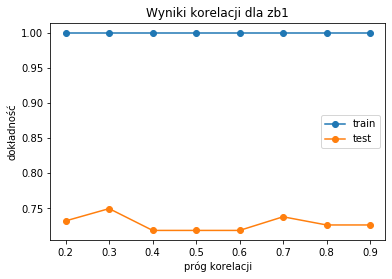

In [170]:
rysuj1(prog,wyniki_trenuj[0],wyniki_testuj[0],'próg korelacji','Wyniki korelacji dla zb1')




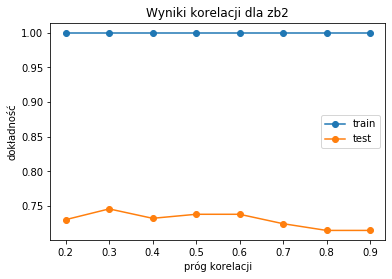

In [171]:
rysuj1(prog,wyniki_trenuj[1],wyniki_testuj[1],'próg korelacji','Wyniki korelacji dla zb2')

# dobór cech na podstawie ważności cech dla drzewa

In [172]:
wyniki_trenuj=[] 
wyniki_testuj=[]

In [173]:
for i, cecha in enumerate(cechy):
    tmp_wyniki_trenuj=[]
    tmp_wyniki_testuj=[]

    model = DecisionTreeClassifier(random_state=0)
    model.fit(X_treningowe[i],y_treningowe[i])
    wagi = list(model.feature_importances_)
    
    lista_cech = []
    for n, w in enumerate(wagi):
        lista_cech.append((w,cecha[n]))
        
    
    lista_cech.sort()
    
    for n in range(len(wagi)) :
        if n > 0:
            lista_cech = lista_cech[1:]
        if n > len(wagi) - 15:
            break
        tmp_cechy = []
        for c in lista_cech:
            tmp_cechy.append(c[1])
        
        ##drzewko
        print(i,' ', tmp_cechy,' ',len(tmp_cechy))
        clf = DecisionTreeClassifier(random_state=0)
        clf.fit(X_treningowe[i][tmp_cechy],y_treningowe[i])
        yt_pred = clf.predict(X_treningowe[i][tmp_cechy])
        y_pred =  clf.predict(X_testowe[i][tmp_cechy])
    
        prec = precision_score(y_testowe[i],y_pred)
        cz = recall_score(y_testowe[i],y_pred)
        try:
            roc = roc_auc_score(y_testowe[i],y_pred)
            dokl = accuracy_score(y_testowe[i],y_pred)
        
        
        #zb_trenujacy_wyniki.append(accuracy_score(y_train,yt_pred))
            tmp_wyniki_trenuj.append(accuracy_score(y_treningowe[i],yt_pred))
            tmp_wyniki_testuj.append(accuracy_score(y_testowe[i],y_pred))
            raport = raportuj(raport,tmp_cechy, 'zb'+str(i), 'feature_importance', prec, cz, roc,dokl)
        except:
            continue
        
        
        
    wyniki_trenuj.append(tmp_wyniki_trenuj)
    wyniki_testuj.append(tmp_wyniki_testuj)

0   ['Padmount Transformer', 'Other', 'WaterExposure', 'GE', 'Schneider Electric', 'Siemens', 'Storm', 'MultipleConnects', 'DF-series Transformer', '1-Phase Pole Transformer', 'MilesFromOcean', 'Repairs', '3-Phase Transformer', 'AssetZip', 'PMLate', 'Voltage Transformer', 'Overloads', 'Lat', 'Long', 'AvgRepairCost', 'Age']   21
0   ['Other', 'WaterExposure', 'GE', 'Schneider Electric', 'Siemens', 'Storm', 'MultipleConnects', 'DF-series Transformer', '1-Phase Pole Transformer', 'MilesFromOcean', 'Repairs', '3-Phase Transformer', 'AssetZip', 'PMLate', 'Voltage Transformer', 'Overloads', 'Lat', 'Long', 'AvgRepairCost', 'Age']   20
0   ['WaterExposure', 'GE', 'Schneider Electric', 'Siemens', 'Storm', 'MultipleConnects', 'DF-series Transformer', '1-Phase Pole Transformer', 'MilesFromOcean', 'Repairs', '3-Phase Transformer', 'AssetZip', 'PMLate', 'Voltage Transformer', 'Overloads', 'Lat', 'Long', 'AvgRepairCost', 'Age']   19
0   ['GE', 'Schneider Electric', 'Siemens', 'Storm', 'MultipleConne

c:\users\kowalma3\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kowalma3\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kowalma3\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kowalma3\appdata\loca

In [174]:
raport

,cechy,zbiór danych,parametry drzewka,precyzja,czułość,roc_auc,dokładność
0,"[Long, AvgRepairCost, MultipleConnects, Storm,...",zb0,korelacje,0.741100,0.797909,0.723516,0.732039
1,"[Long, 3-Phase Transformer, AvgRepairCost, Mul...",zb0,korelacje,0.763333,0.797909,0.743253,0.749515
2,"[Long, 3-Phase Transformer, Padmount Transform...",zb0,korelacje,0.751773,0.738676,0.715829,0.718447
3,"[Long, 3-Phase Transformer, Padmount Transform...",zb0,korelacje,0.751773,0.738676,0.715829,0.718447
4,"[Long, 3-Phase Transformer, Padmount Transform...",zb0,korelacje,0.751773,0.738676,0.715829,0.718447
5,"[Long, Other, AvgRepairCost, WaterExposure, Vo...",zb0,korelacje,0.765734,0.763066,0.734603,0.737864
6,"[Long, Other, AvgRepairCost, WaterExposure, Vo...",zb0,korelacje,0.748299,0.766551,0.720995,0.726214
7,"[Long, Other, GE, AvgRepairCost, WaterExposure...",zb0,korelacje,0.744966,0.773519,0.720093,0.726214
8,"[Long, MultipleConnects, AvgRepairCost_log10, ...",zb1,korelacje,0.735669,0.804878,0.720421,0.730097
9,"[Long, 3-Phase Transformer, MultipleConnects, ...",zb1,korelacje,0.765306,0.783972,0.740670,0.745631


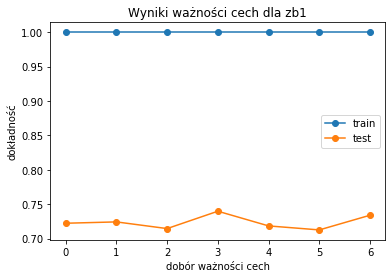

In [182]:
x = range(len(wyniki_trenuj[0]))
rysuj1(x,wyniki_trenuj[0],wyniki_testuj[0],'dobór ważności cech','Wyniki ważności cech dla zb1')

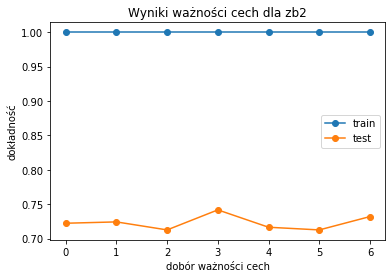

In [183]:
x = range(len(wyniki_trenuj[1]))
rysuj1(x,wyniki_trenuj[1],wyniki_testuj[1],'dobór ważności cech','Wyniki ważności cech dla zb2')

# dobór manualny cech

In [187]:
cechy_manualne = [
    ['PMLate', 'WaterExposure', 'Storm', 'AssetZip', 'Age', 'Schneider Electric', 'Siemens', '1-Phase Pole Transformer', '3-Phase Transformer', 'Overloads', 'MilesFromOcean'],
    ['PMLate', 'WaterExposure', 'Storm', 'AssetZip', 'AvgRepairCost_log10', 'Age_log10', 'Schneider Electric', 'Siemens', '1-Phase Pole Transformer', '3-Phase Transformer', 'Overloads', 'MilesFromOcean'],
    ['PMLate', 'WaterExposure', 'Storm', 'AssetZip', 'Age', 'Schneider Electric', 'Siemens', '1-Phase Pole Transformer', '3-Phase Transformer', 'Overloads', 'MilesFromOcean'],
]

for i, cecha in enumerate(cechy_manualne):
    
    tmp_cechy = cecha
    
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_treningowe[i][tmp_cechy],y_treningowe[i])
    yt_pred = clf.predict(X_treningowe[i][tmp_cechy])
    y_pred =  clf.predict(X_testowe[i][tmp_cechy])
    
    prec = precision_score(y_testowe[i],y_pred)
    cz = recall_score(y_testowe[i],y_pred)
    try:
        roc = roc_auc_score(y_testowe[i],y_pred)
        dokl = accuracy_score(y_testowe[i],y_pred)
               
        tmp_wyniki_trenuj.append(accuracy_score(y_treningowe[i],yt_pred))
        tmp_wyniki_testuj.append(accuracy_score(y_testowe[i],y_pred))
        raport = raportuj(raport,tmp_cechy, 'zb'+str(i), 'manualnu dobór cech', prec, cz, roc,dokl)
    except:
        continue

c:\users\kowalma3\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kowalma3\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [188]:
raport

,cechy,zbiór danych,parametry drzewka,precyzja,czułość,roc_auc,dokładność
0,"[Long, AvgRepairCost, MultipleConnects, Storm,...",zb0,korelacje,0.741100,0.797909,0.723516,0.732039
1,"[Long, 3-Phase Transformer, AvgRepairCost, Mul...",zb0,korelacje,0.763333,0.797909,0.743253,0.749515
2,"[Long, 3-Phase Transformer, Padmount Transform...",zb0,korelacje,0.751773,0.738676,0.715829,0.718447
3,"[Long, 3-Phase Transformer, Padmount Transform...",zb0,korelacje,0.751773,0.738676,0.715829,0.718447
4,"[Long, 3-Phase Transformer, Padmount Transform...",zb0,korelacje,0.751773,0.738676,0.715829,0.718447
5,"[Long, Other, AvgRepairCost, WaterExposure, Vo...",zb0,korelacje,0.765734,0.763066,0.734603,0.737864
6,"[Long, Other, AvgRepairCost, WaterExposure, Vo...",zb0,korelacje,0.748299,0.766551,0.720995,0.726214
7,"[Long, Other, GE, AvgRepairCost, WaterExposure...",zb0,korelacje,0.744966,0.773519,0.720093,0.726214
8,"[Long, MultipleConnects, AvgRepairCost_log10, ...",zb1,korelacje,0.735669,0.804878,0.720421,0.730097
9,"[Long, 3-Phase Transformer, MultipleConnects, ...",zb1,korelacje,0.765306,0.783972,0.740670,0.745631


# trenowanie ze zmianą parametru max_depth

In [193]:
max_depths = np.linspace(1, 20, 20, endpoint=True)


ile_wierszy_sprawdzać = len(raport)

In [195]:
for j,cechy in enumerate(raport['cechy']):
    
    tmp_cechy = cechy
    for element in max_depths:
        i=0
        if 'zb0' in raport['zbiór danych'].iloc[j]:
            i=0
        elif 'zb1' in raport['zbiór danych'].iloc[j]:
            i=1
        else:
            i =2
        
        clf = DecisionTreeClassifier(max_depth=element,random_state=0)
        clf.fit(X_treningowe[i][tmp_cechy],y_treningowe[i])
        yt_pred = clf.predict(X_treningowe[i][tmp_cechy])
        y_pred = clf.predict(X_testowe[i][tmp_cechy])
    
        prec = precision_score(y_testowe[i],y_pred)
        cz = recall_score(y_testowe[i],y_pred)
        
        roc = roc_auc_score(y_testowe[i],y_pred)
        dokl = accuracy_score(y_testowe[i],y_pred)
        
        
        
        opis = raport['parametry drzewka'].iloc[j] + ', max-depth= '+ str(element)
        raport = raportuj(raport,tmp_cechy, 'zb'+str(i), opis, prec, cz, roc,dokl)


In [197]:
max(raport['dokładność'])

0.8116504854368932

# parametr min_samples_split

In [200]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

In [202]:
for j,cechy in enumerate(raport['cechy']):
    if j> ile_wierszy_sprawdzać:
        break
    tmp_cechy = cechy
    for element in min_samples_splits:
        i=0
        if 'zb0' in raport['zbiór danych'].iloc[j]:
            i=0
        elif 'zb1' in raport['zbiór danych'].iloc[j]:
            i=1
        else:
            i =2
        
        clf = DecisionTreeClassifier(min_samples_split=element,random_state=0)
        clf.fit(X_treningowe[i][tmp_cechy],y_treningowe[i])
        yt_pred = clf.predict(X_treningowe[i][tmp_cechy])
        y_pred = clf.predict(X_testowe[i][tmp_cechy])
    
        prec = precision_score(y_testowe[i],y_pred)
        cz = recall_score(y_testowe[i],y_pred)
        
        roc = roc_auc_score(y_testowe[i],y_pred)
        dokl = accuracy_score(y_testowe[i],y_pred)
        
        
        
        opis = raport['parametry drzewka'].iloc[j] + ', min_samples_split= '+ str(element)
        raport = raportuj(raport,tmp_cechy, 'zb'+str(i), opis, prec, cz, roc,dokl)

In [203]:
max(raport['dokładność'])

0.8116504854368932

# parametr min_samples_leaf

In [204]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)

In [205]:
for j,cechy in enumerate(raport['cechy']):
    if j> ile_wierszy_sprawdzać:
        break
    tmp_cechy = cechy
    for element in min_samples_leafs:
        i=0
        if 'zb0' in raport['zbiór danych'].iloc[j]:
            i=0
        elif 'zb1' in raport['zbiór danych'].iloc[j]:
            i=1
        else:
            i =2
        
        clf = DecisionTreeClassifier(min_samples_leaf=element,random_state=0)
        clf.fit(X_treningowe[i][tmp_cechy],y_treningowe[i])
        yt_pred = clf.predict(X_treningowe[i][tmp_cechy])
        y_pred = clf.predict(X_testowe[i][tmp_cechy])
    
        prec = precision_score(y_testowe[i],y_pred)
        cz = recall_score(y_testowe[i],y_pred)
        
        roc = roc_auc_score(y_testowe[i],y_pred)
        dokl = accuracy_score(y_testowe[i],y_pred)
        
        
        
        opis = raport['parametry drzewka'].iloc[j] + ', min_samples_leaf= '+ str(element)
        raport = raportuj(raport,tmp_cechy, 'zb'+str(i), opis, prec, cz, roc,dokl)

In [206]:
max(raport['dokładność'])

0.8116504854368932

# parametr max_features

In [207]:


for j,cechy in enumerate(raport['cechy']):
    if j> ile_wierszy_sprawdzać:
        break
    tmp_cechy = cechy
    ile_cech = list(range(4,len(tmp_cechy)))
    for element in ile_cech:
        i=0
        if 'zb0' in raport['zbiór danych'].iloc[j]:
            i=0
        elif 'zb1' in raport['zbiór danych'].iloc[j]:
            i=1
        else:
            i =2
        
        clf = DecisionTreeClassifier(max_features=element,random_state=0)
        clf.fit(X_treningowe[i][tmp_cechy],y_treningowe[i])
        yt_pred = clf.predict(X_treningowe[i][tmp_cechy])
        y_pred = clf.predict(X_testowe[i][tmp_cechy])
    
        prec = precision_score(y_testowe[i],y_pred)
        cz = recall_score(y_testowe[i],y_pred)
        
        roc = roc_auc_score(y_testowe[i],y_pred)
        dokl = accuracy_score(y_testowe[i],y_pred)
        
        
        
        opis = raport['parametry drzewka'].iloc[j] + ', max_features= '+ str(element)
        raport = raportuj(raport,tmp_cechy, 'zb'+str(i), opis, prec, cz, roc,dokl)

In [208]:
max(raport['dokładność'])

0.8116504854368932

# Dobór parametrów gridsearchcv, wykonuje się bardzo długo, nie polecam uruchamiać

In [210]:
from sklearn.model_selection import GridSearchCV

In [211]:
for j,cechy in enumerate(raport['cechy']):
    if j> ile_wierszy_sprawdzać:
        break
        
    print('wiersz : ',j)
    tmp_cechy = cechy
    
    param_grid = [{
    'max_depth':np.linspace(1, 32, 32, endpoint=True),
    'min_samples_split':np.linspace(0.1, 1.0, 10, endpoint=True),
    'min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint=True),
    'max_features':list(range(4,len(tmp_cechy)))
}]
    
    i=0
    if 'zb0' in raport['zbiór danych'].iloc[j]:
        i=0
    elif 'zb1' in raport['zbiór danych'].iloc[j]:
        i=1
    else:
        i =2
            
    model = DecisionTreeClassifier(random_state=0)
    grid_search = GridSearchCV(model,param_grid,cv=2,scoring='accuracy')
    grid_search.fit(X_treningowe[i][tmp_cechy],y_treningowe[i])
    y_pred = grid_search.best_estimator_.predict(X_testowe[i][tmp_cechy])
    prec = precision_score(y_testowe[i],y_pred)
    cz = recall_score(y_testowe[i],y_pred)
        
    roc = roc_auc_score(y_testowe[i],y_pred)
    dokl = accuracy_score(y_testowe[i],y_pred)
        
    
    param = grid_search.best_params_
        
    opis = raport['parametry drzewka'].iloc[j] + ', grid= '+ str(param)
    raport = raportuj(raport,tmp_cechy, 'zb'+str(i), opis, prec, cz, roc,dokl)

wiersz :  0
wiersz :  1
wiersz :  2
wiersz :  3
wiersz :  4
wiersz :  5
wiersz :  6
wiersz :  7
wiersz :  8
wiersz :  9
wiersz :  10
wiersz :  11
wiersz :  12
wiersz :  13
wiersz :  14
wiersz :  15
wiersz :  16
wiersz :  17
wiersz :  18
wiersz :  19
wiersz :  20
wiersz :  21
wiersz :  22
wiersz :  23
wiersz :  24
wiersz :  25
wiersz :  26
wiersz :  27
wiersz :  28
wiersz :  29
wiersz :  30
wiersz :  31
wiersz :  32
wiersz :  33
wiersz :  34
wiersz :  35
wiersz :  36
wiersz :  37
wiersz :  38


In [212]:
max(raport['dokładność'])

0.8116504854368932

In [213]:
len(raport)

1881

# rekurencyjny dobór cech

In [214]:
from sklearn.feature_selection import RFECV

In [221]:
for j,cechy in enumerate(raport['cechy']):
    if j> ile_wierszy_sprawdzać:
        break
        
    print('wiersz : ',j)
    
    model = DecisionTreeClassifier(random_state=0)

    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2), scoring='accuracy')
    
    i=0
    if 'zb0' in raport['zbiór danych'].iloc[j]:
        
        i=0
    elif 'zb1' in raport['zbiór danych'].iloc[j]:
        i=1
    else:
        i =2
        
    rfecv.fit(X_treningowe[i][cechy],y_treningowe[i])
    print(len(cechy))
    print(rfecv.grid_scores_)

    tmp_cechy = []
    for n, element in enumerate(rfecv.grid_scores_):
    
        if n > (len(cechy)-rfecv.n_features_-1):
            tmp_cechy.append(cechy[n])
 

    print(tmp_cechy)
            
    model = DecisionTreeClassifier(random_state=0)
    
    model.fit(X_treningowe[i][tmp_cechy],y_treningowe[i])
    y_pred = model.predict(X_testowe[i][tmp_cechy])
    prec = precision_score(y_testowe[i],y_pred)
    cz = recall_score(y_testowe[i],y_pred)
        
    roc = roc_auc_score(y_testowe[i],y_pred)
    dokl = accuracy_score(y_testowe[i],y_pred)
        
   
    opis = raport['parametry drzewka'].iloc[j] + ', dobór cech rekurencyjny '
    raport = raportuj(raport,tmp_cechy, 'zb'+str(i), opis, prec, cz, roc,dokl)

wiersz :  0
10
[0.65945369 0.64943566 0.64446478 0.64194953 0.70605657 0.67942041
 0.7043802  0.72354548 0.72688575 0.71106489]
['AvgRepairCost', 'MultipleConnects', 'Storm', 'Repairs', 'Overloads', 'AssetZip', 'MilesFromOcean', 'Age', 'PMLate']
wiersz :  1
12
[0.65945369 0.64943566 0.64446478 0.64194953 0.70605657 0.67942041
 0.7043802  0.71938575 0.71770383 0.71688159 0.72603855 0.7185538 ]
['3-Phase Transformer', 'AvgRepairCost', 'MultipleConnects', 'Storm', 'Repairs', 'Overloads', '1-Phase Pole Transformer', 'AssetZip', 'MilesFromOcean', 'Age', 'PMLate']
wiersz :  2
16
[0.65945369 0.64943566 0.64446478 0.64194953 0.70605657 0.69025374
 0.70688852 0.70271353 0.72104132 0.72439407 0.73271769 0.73271631
 0.72856073 0.72355519 0.72522185 0.72854687]
['Voltage Transformer', 'Storm', 'Repairs', 'Overloads', '1-Phase Pole Transformer', 'AssetZip', 'MilesFromOcean', 'PMLate', 'Age', 'Siemens', 'Schneider Electric']
wiersz :  3
16
[0.65945369 0.64943566 0.64446478 0.64194953 0.70605657 0.69

wiersz :  20
17
[0.65945369 0.64943566 0.64446478 0.64195092 0.63196339 0.66277177
 0.69523572 0.69109262 0.71024681 0.71524126 0.71024126 0.71607044
 0.72357044 0.71940377 0.72272879 0.72273295 0.72188713]
['DF-series Transformer', '1-Phase Pole Transformer', 'MilesFromOcean', 'Repairs', '3-Phase Transformer', 'AssetZip', 'PMLate', 'Voltage Transformer', 'Overloads', 'Lat', 'Long', 'AvgRepairCost', 'Age']
wiersz :  21
16
[0.65945369 0.64943566 0.64446478 0.64195092 0.63196339 0.66277177
 0.69523572 0.69109262 0.71024681 0.71524126 0.71024126 0.7152371
 0.72107044 0.70857044 0.71939545 0.71106628]
['DF-series Transformer', '1-Phase Pole Transformer', 'MilesFromOcean', 'Repairs', '3-Phase Transformer', 'AssetZip', 'PMLate', 'Voltage Transformer', 'Overloads', 'Lat', 'Long', 'AvgRepairCost', 'Age']
wiersz :  22
15
[0.65945369 0.64943566 0.64446478 0.64195092 0.63196339 0.66277177
 0.69523572 0.69109262 0.71024681 0.71524126 0.71024126 0.70691764
 0.73022185 0.72188991 0.7202274 ]
['DF-se

In [222]:
max(raport['dokładność'])

0.8155339805825242

In [223]:
len(raport)

1920

# zapis raportu

In [224]:
raport.to_excel('raport.xlsx')

In [225]:
max_dokl = max(raport['dokładność'])
for i, dokl in enumerate(raport['dokładność']):
    if dokl == max_dokl:
        print('Najlepsze cechy:')
        print(raport['cechy'].iloc[i])
        print('Numer wiersza w raporcie: ', i)
        

Najlepsze cechy:
['Age', 'Schneider Electric', 'Siemens', '1-Phase Pole Transformer', '3-Phase Transformer', 'Overloads', 'MilesFromOcean']
Numer wiersza w raporcie:  1915
Najlepsze cechy:
['Age', 'Schneider Electric', 'Siemens', '1-Phase Pole Transformer', '3-Phase Transformer', 'Overloads', 'MilesFromOcean']
Numer wiersza w raporcie:  1917


In [226]:
max_dokl

0.8155339805825242